In [1]:
import pandas as pd
df_train = pd.read_json("../data/pilener/pilener_train.json")

# -------------------------------------------------------------------
# Counting Number of Occurences per Label
# -------------------------------------------------------------------
from collections import Counter

label_counter = Counter()
for idx, entry in df_train.iterrows():
    
    ner_string = entry.ner
    for annotation in ner_string:
        if len(annotation) >= 3:
            label = annotation[2]
            label_lower = label.lower()
            label_counter[label_lower] += 1
            
# -------------------------------------------------------------------
# DataFrame Creation
# -------------------------------------------------------------------
df = pd.DataFrame.from_dict(label_counter, orient='index', columns=["count"]).reset_index().rename(columns={"index": "label"})

In [2]:
import numpy as np
import pandas as pd
from FlagEmbedding import FlagModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pickle
import warnings
import logging
import os

warnings.filterwarnings('ignore')
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('transformers').setLevel(logging.ERROR)
logging.getLogger('FlagEmbedding').setLevel(logging.ERROR)

# -------------------------------------------------------------------
# Consolidating NER Labels
# -------------------------------------------------------------------
def consolidate_ner_labels(df: pd.DataFrame, 
                           min_count_threshold: int = 50, 
                           similarity_threshold: float = 0.9, 
                           batch_size: int = 1024, 
                           save_embeddings: bool =True):
    """
    Consolidate rare NER labels by mapping them to semantically similar frequent labels.

    Args:
        df: DataFrame with columns 'label' and 'count'
        min_count_threshold: Minimum count for a label to be considered frequent (default: 50)
        similarity_threshold: Minimum cosine similarity for mapping (default: 0.9)
        batch_size: Batch size for embedding computation (default: 512)
        save_embeddings: Whether to save embeddings to disk for reuse (default: True)

    Returns:
        dict: Mapping from rare labels to frequent labels
    """

    print("Loading BGE-en-large model...")
    model = FlagModel('BAAI/bge-large-en-v1.5', 
                      query_instruction_for_retrieval="Represent this entity type for semantic similarity search: ",
                      use_fp16=True)

    frequent_labels = df[df['count'] > min_count_threshold]['label'].tolist()
    rare_labels = df[df['count'] <= min_count_threshold]['label'].tolist()

    print(f"Frequent labels (>{min_count_threshold}): {len(frequent_labels)}")
    print(f"Rare labels (<=1): {len(rare_labels)}")

    print("\nComputing embeddings for frequent labels...")
    frequent_embeddings = []

    for i in tqdm(range(0, len(frequent_labels), batch_size)):
        batch = frequent_labels[i:i+batch_size]
        embeddings = model.encode(batch)
        frequent_embeddings.extend(embeddings)

    frequent_embeddings = np.array(frequent_embeddings)

    if save_embeddings:
        np.save('frequent_label_embeddings.npy', frequent_embeddings)
        with open('frequent_labels.pkl', 'wb') as f:
            pickle.dump(frequent_labels, f)
        print("Saved frequent label embeddings to disk")

    rename_dict = {}
    processed = 0

    print(f"\nProcessing {len(rare_labels)} rare labels...")

    for i in tqdm(range(0, len(rare_labels), batch_size)):
        batch_rare = rare_labels[i:i+batch_size]

        rare_embeddings = model.encode(batch_rare)

        similarities = cosine_similarity(rare_embeddings, frequent_embeddings)

        for j, rare_label in enumerate(batch_rare):
            max_sim_idx = np.argmax(similarities[j])
            max_sim = similarities[j][max_sim_idx]

            if max_sim >= similarity_threshold:
                best_match = frequent_labels[max_sim_idx]
                rename_dict[rare_label] = best_match

                if processed < 10 or processed % 1000 == 0:
                    print(f"  '{rare_label}' -> '{best_match}' (similarity: {max_sim:.3f})")

            processed += 1

    print(f"\nTotal mappings created: {len(rename_dict)} out of {len(rare_labels)} rare labels")
    print(f"Mapping rate: {len(rename_dict)/len(rare_labels)*100:.1f}%")

    return rename_dict

C:\Users\brk.ch\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\brk.ch\AppData\Roaming\Python\Python312\site-packages\triton\windows_utils.py:372: UserWarning: Failed to find CUDA.
  warnings.warn("Failed to find CUDA.")


In [3]:
rename_dict = consolidate_ner_labels(df, min_count_threshold=10, similarity_threshold=0.80)

Loading BGE-en-large model...
Frequent labels (>10): 2340
Rare labels (<=1): 10280

Computing embeddings for frequent labels...


pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 235.34it/s]

pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 200.01it/s]

pre tokenize: 100%|██████████| 2/2 [00:00<00:00, 333.34it/s]

100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Saved frequent label embeddings to disk

Processing 10280 rare labels...


pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 444.68it/s]

  9%|▉         | 1/11 [00:01<00:15,  1.52s/it]

  'musicgroup' -> 'music group' (similarity: 0.976)
  'protein motif' -> 'motif' (similarity: 0.855)
  'judicial district' -> 'district' (similarity: 0.822)
  'app_name' -> 'package_name' (similarity: 0.814)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 500.13it/s]

 18%|█▊        | 2/11 [00:03<00:15,  1.72s/it]

  'dna base' -> 'genetic base' (similarity: 0.855)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 493.75it/s]

 27%|██▋       | 3/11 [00:04<00:13,  1.67s/it]

  'army' -> 'military' (similarity: 0.844)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 499.86it/s]

 36%|███▋      | 4/11 [00:06<00:11,  1.60s/it]

  'data-type' -> 'data type' (similarity: 0.956)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 531.77it/s]

pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 570.96it/s]

pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 571.47it/s]

 64%|██████▎   | 7/11 [00:12<00:07,  1.80s/it]

  'compound class' -> 'compound' (similarity: 0.843)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 499.96it/s]

 73%|███████▎  | 8/11 [00:14<00:05,  1.99s/it]

  'military force' -> 'military unit' (similarity: 0.825)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 571.55it/s]

 82%|████████▏ | 9/11 [00:16<00:03,  1.87s/it]

  'image program' -> 'image type' (similarity: 0.806)



pre tokenize: 100%|██████████| 4/4 [00:00<00:00, 444.18it/s]

 91%|█████████ | 10/11 [00:18<00:01,  1.93s/it]

  'duration of time' -> 'duration' (similarity: 0.921)


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]



Total mappings created: 4523 out of 10280 rare labels
Mapping rate: 44.0%


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# -------------------------------------------------------------------
# Visualization
# -------------------------------------------------------------------
def plot_entity_distribution(df_original, df_consolidated, figsize=(15, 6)):
    """
    Plot side-by-side histograms of entity count distributions.
    
    Args:
        df_original: Original DataFrame with 'label' and 'count' columns
        df_consolidated: Consolidated DataFrame with 'label' column
        figsize: Figure size (default: (15, 6))
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    max_count = max(df_original['count'].max(), df_consolidated['count'].max())
    bins = np.logspace(0, np.log10(max_count + 1), 50)
    
    counts1, _, _ = ax1.hist(df_original['count'], bins=bins, alpha=0.7, color='steelblue', 
                             edgecolor='black', linewidth=0.5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Entity Count (log scale)', fontsize=12)
    ax1.set_ylabel('Number of Entities (log scale)', fontsize=12)
    ax1.set_title(f'Original Distribution ({df_original["label"].nunique():,} unique entities)', fontsize=14, fontweight="bold")
    ax1.grid(True, alpha=0.3)
    
    ax1.text(0.95, 0.95, f'Entities with count=1: {(df_original["count"]==1).sum():,}', 
             transform=ax1.transAxes, ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    counts2, _, _ = ax2.hist(df_consolidated['count'], bins=bins, alpha=0.7, color='darkgreen', 
                         edgecolor='black', linewidth=0.5)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Entity Count (log scale)', fontsize=12)
    ax2.set_ylabel('Number of Entities (log scale)', fontsize=12)
    ax2.set_title(f'Consolidated Distribution ({df_consolidated["label"].nunique():,} unique entities)', fontsize=14, fontweight="bold")
    ax2.grid(True, alpha=0.3)
    
    ax2.text(0.95, 0.95, f'Entities with count=1: {(df_consolidated["count"]==1).sum():,}', 
             transform=ax2.transAxes, ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    max_y = max(counts1.max(), counts2.max())
    y_min = 0.8
    y_max = max_y * 1.5
    
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.savefig("../output/pilener_preprocessing/entity_reduction.png")
    plt.show()
    
    print("\nDistribution Summary:")
    print("="*50)
    print(f"Original: {df_original['label'].nunique():,} unique entities")
    print(f"  - Singleton entities (count=1): {(df_original['count']==1).sum():,}")
    print(f"  - Rare entities (count<=5): {(df_original['count']<=5).sum():,}")
    print(f"  - Mean count: {df_original['count'].mean():.2f}")
    print(f"  - Median count: {df_original['count'].median():.0f}")
    
    print(f"\nConsolidated: {df_consolidated['label'].nunique():,} unique entities")
    print(f"  - Singleton entities (count=1): {(df_consolidated['count']==1).sum():,}")
    print(f"  - Rare entities (count<=5): {(df_consolidated['count']<=5).sum():,}")
    print(f"  - Mean count: {df_consolidated['count'].mean():.2f}")
    print(f"  - Median count: {df_consolidated['count'].median():.0f}")

In [5]:
import pandas as pd
from tqdm import tqdm

# -------------------------------------------------------------------
# Entity Renaming
# -------------------------------------------------------------------
def rename_entities_in_dataframe(df_train, rename_dict, batch_size=10000):
    """
    Efficiently rename entities in the original dataframe based on the rename_dict.
    
    Args:
        df_train: Original dataframe with 'ner' column containing entity annotations
        rename_dict: Dictionary mapping rare labels to frequent labels
        batch_size: Number of rows to process at once for memory efficiency
    
    Returns:
        DataFrame with renamed entities
    """
    
    df_renamed = df_train.copy()
    
    rename_dict_lower = {k.lower(): v for k, v in rename_dict.items()}
    
    def rename_entities_in_row(ner_annotations):
        """Process a single row's NER annotations"""
        if not isinstance(ner_annotations, list):
            return ner_annotations
        
        renamed_annotations = []
        for annotation in ner_annotations:
            if len(annotation) >= 3:
                new_annotation = list(annotation)
                label = annotation[2]
                label_lower = label.lower()
                
                if label_lower in rename_dict_lower:
                    new_annotation[2] = rename_dict_lower[label_lower]
                
                renamed_annotations.append(new_annotation)
            else:
                renamed_annotations.append(annotation)
        
        return renamed_annotations
    
    print(f"Renaming entities in {len(df_renamed)} rows...")
    
    if len(df_renamed) > batch_size:
        for i in tqdm(range(0, len(df_renamed), batch_size)):
            end_idx = min(i + batch_size, len(df_renamed))
            df_renamed.loc[i:end_idx-1, 'ner'] = df_renamed.loc[i:end_idx-1, 'ner'].apply(rename_entities_in_row)
    else:
        df_renamed['ner'] = df_renamed['ner'].apply(rename_entities_in_row)
    
    return df_renamed

In [7]:
df_train_renamed = rename_entities_in_dataframe(df_train, rename_dict)

print("\nVerifying renaming...")
print(f"Original dataframe shape: {df_train.shape}")
print(f"Renamed dataframe shape: {df_train_renamed.shape}")

Renaming entities in 45889 rows...


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Verifying renaming...
Original dataframe shape: (45889, 3)
Renamed dataframe shape: (45889, 3)


In [8]:
label_counter_after = Counter()
for idx, entry in df_train_renamed.iterrows():
    ner_string = entry.ner
    for annotation in ner_string:
        if len(annotation) >= 3:
            label = annotation[2]
            label_lower = label.lower()
            label_counter_after[label_lower] += 1

df_after = pd.DataFrame.from_dict(label_counter_after, orient='index', columns=["count"]).reset_index().rename(columns={"index": "label"})
print(f"\nUnique labels before: {len(label_counter)}")
print(f"Unique labels after: {len(label_counter_after)}")
print(f"Reduction: {len(label_counter) - len(label_counter_after)} labels")


Unique labels before: 12620
Unique labels after: 8097
Reduction: 4523 labels


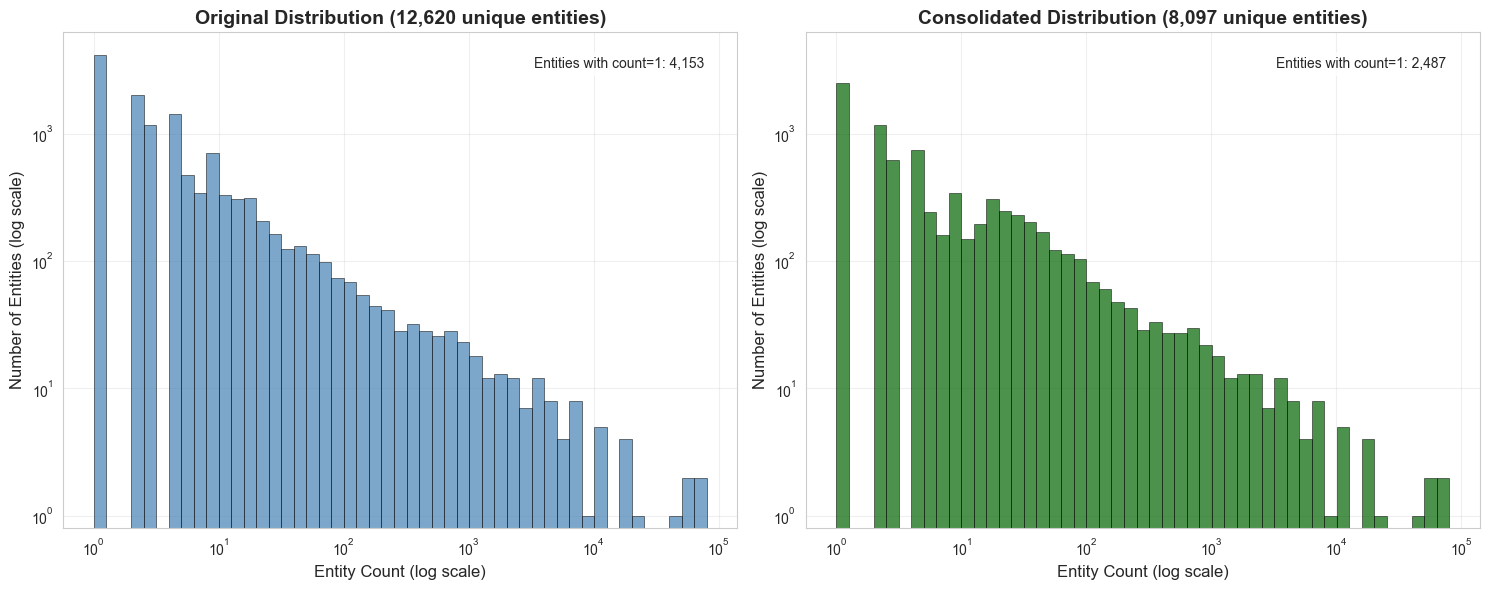


Distribution Summary:
Original: 12,620 unique entities
  - Singleton entities (count=1): 4,153
  - Rare entities (count<=5): 8,762
  - Mean count: 74.46
  - Median count: 3

Consolidated: 8,097 unique entities
  - Singleton entities (count=1): 2,487
  - Rare entities (count<=5): 5,014
  - Mean count: 116.05
  - Median count: 3


In [9]:
# Visualization
plot_entity_distribution(df, df_after)

In [10]:
# -------------------------------------------------------------------
# Serializing Cleaned Training Data
# -------------------------------------------------------------------
df_train_renamed.to_json("nuner_preprocessed_augmented.json",orient="records")